## ARIMA implementation (Tesla)

A Python implementation for ARIMA Time series forecasting

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
sns.set_theme(style="darkgrid")
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters, autocorrelation_plot
register_matplotlib_converters()

#libraries used

We begin by doing a functional approach to a particular stock, namely Tesla during 2019. From there we will aim to make it object oriented so that we can call a time forecast for any stock over any period.

In [31]:
df = pd.read_csv("TSLA.csv", parse_dates=[0])

In [32]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,84.900002,86.139999,84.342003,86.052002,86.052002,47660500
1,2020-01-03,88.099998,90.800003,87.384003,88.601997,88.601997,88892500
2,2020-01-06,88.094002,90.311996,88.000000,90.307999,90.307999,50665000
3,2020-01-07,92.279999,94.325996,90.671997,93.811996,93.811996,89410500
4,2020-01-08,94.739998,99.697998,93.646004,98.428001,98.428001,155721500


We use the closing prices to model off of.

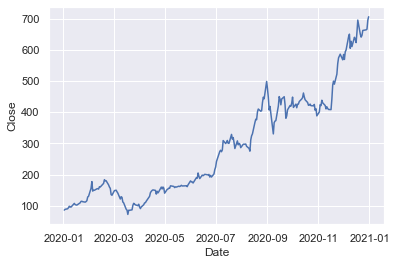

In [33]:
sns.lineplot(y = "Close",x = "Date", data = df);

Just by "looking" we can see that the data isn't stationary, but we plot a rolling mean/std to check.

In [47]:
df['rolling_mean'] = df['Close'].rolling(window = 7).mean().shift(-3)
df['rolling_std']  = df['Close'].rolling(window = 7).std().shift(-3)

In [48]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,rolling_mean,rolling_std
0,2020-01-02,84.900002,86.139999,84.342003,86.052002,86.052002,47660500,NaN,NaN
1,2020-01-03,88.099998,90.800003,87.384003,88.601997,88.601997,88892500,NaN,NaN
2,2020-01-06,88.094002,90.311996,88.000000,90.307999,90.307999,50665000,NaN,NaN
3,2020-01-07,92.279999,94.325996,90.671997,93.811996,93.811996,89410500,92.728570,4.510497
4,2020-01-08,94.739998,99.697998,93.646004,98.428001,98.428001,155721500,95.431427,5.419939
...,...,...,...,...,...,...,...,...,...
248,2020-12-24,642.989990,666.090027,641.000000,661.770020,661.770020,22865600,660.344290,18.015480
249,2020-12-28,674.510010,681.400024,660.799988,663.690002,663.690002,32278600,668.317147,23.968305
250,2020-12-29,661.000000,669.900024,655.000000,665.989990,665.989990,22910800,NaN,NaN
251,2020-12-30,672.000000,696.599976,668.359985,694.780029,694.780029,42846000,NaN,NaN


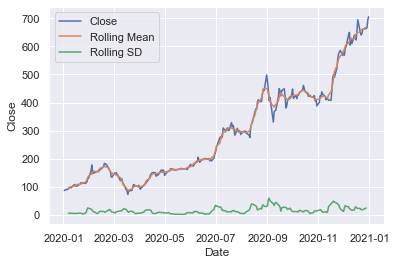

In [81]:
sns.lineplot(y = "Close",x = "Date", data = df);
sns.lineplot(y = "rolling_mean",x = "Date", data = df);
sns.lineplot(y = "rolling_std",x = "Date", data = df);
plt.legend(labels=['Close', 'Rolling Mean', 'Rolling SD']);

As can be seen there are issues with both the rolling mean and std. Indeed they both appear to be increasing with time. However, before resorting to an ADF test we can improve on this: since we are working with stock data, it makes sense to take the log of the closing prices, since we only care about ratio changes of our stocks.

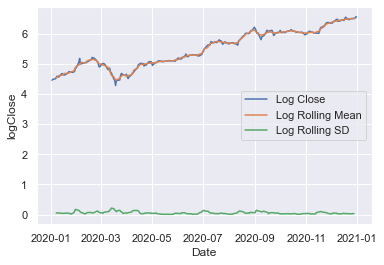

In [86]:
df["logClose"] = np.log(df["Close"])
sns.lineplot(y = "logClose",x = "Date", data = df);
df['log_rolling_mean'] = df['logClose'].rolling(window = 7).mean().shift(-3);
df['log_rolling_std']  = df['logClose'].rolling(window = 7).std().shift(-3);
sns.lineplot(y = "log_rolling_mean",x = "Date", data = df);
sns.lineplot(y = "log_rolling_std",x = "Date", data = df);
plt.legend(labels=['Log Close', 'Log Rolling Mean', 'Log Rolling SD']);

As can be seen the problems with the variance appear to have vanished, though the mean still appears to be increasing.std. Indeed they both appear to be increasing with time. We perform the Augmented Dickey-Fuller test to confirm our hypothesis:

In [59]:
result = adfuller(df['Close'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))


ADF Statistic: 0.7978615551167465
p-value: 0.9916015709875191
Critical Values:
	1%: -3.4565688966099373
	5%: -2.8730786194395455
	10%: -2.5729189953388762


Indeed the ADF statistic is even positive in this case, so we can automatically reject the null hypothesis that there isn't a unit root.

We now do an ACF test to check if there is any MA contribution to our model:

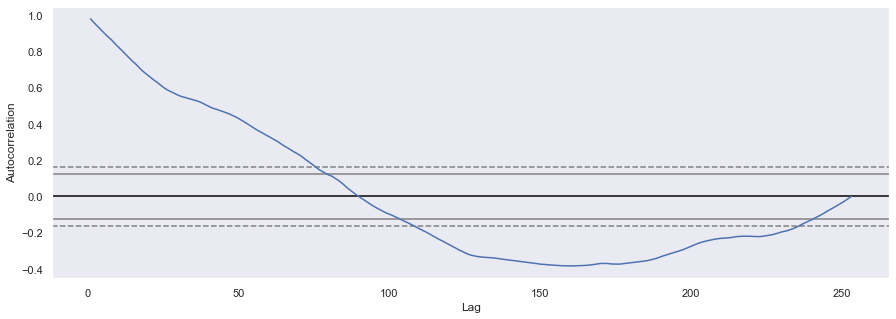

In [79]:
fig, ax = plt.subplots(figsize=(15, 5));
autocorrelation_plot(df['Close'], ax=ax);

As can be seen on the ACF test there is a significant autocorrelation at around the 60 lag mark. We do a PACF test to check our findings.

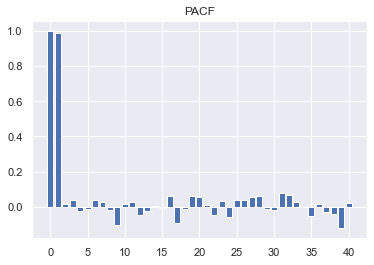

In [80]:
from statsmodels.tsa.stattools import pacf
plt.bar(x=np.arange(0,41), height=pacf(df.Close, nlags=40));
plt.title("PACF");

However, from a PACF test, we see that only the most recent lag has any impact. We therefore do an AR(1) test.

From this point the next thing we need to do is to make our data stationary - ie transform it into a set of data with zero mean. To do this we take the difference between successive data points. Since we have taken the logarithm of our data, this gives us the intraday ratios instead (useful given that we assume that stocks are log-normally distributed as in StoCalc)

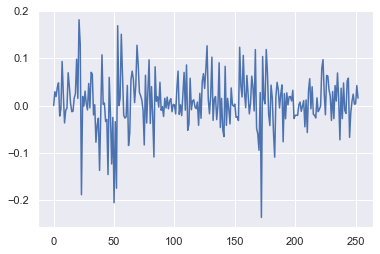

In [116]:
# Make the data stationary by differencing
tsla = df.logClose.diff().fillna(0)
# Create lag
tsla_lag_1 = tsla.shift(1).fillna(0)
# Put all into one DataFrame
df_regression = pd.DataFrame(tsla)
df_regression["Lag1"] = tsla_lag_1
# Split into train and test data
df_regression_train = df_regression.iloc[0:200]
df_regression_test = df_regression.iloc[200:]
tsla.plot();

In [117]:
df_regression_train

,logClose,Lag1
0,0.000000,0.000000
1,0.029203,0.000000
2,0.019072,0.029203
3,0.038067,0.019072
4,0.048033,0.038067
...,...,...
195,0.018793,0.001457
196,0.018944,0.018793
197,0.009787,0.018944
198,0.032273,0.009787


In [118]:
df_regression.Lag1.mean()

0.008255507915021077

In [119]:
df_regression.Lag1.std()

0.056379816582729905

As can be seen, our variance and mean of the data is very close to zero - essentially we have made our data stationary for the purposes of the analysis.

To work out how many data points are useful, we record the r-squared value over an 'expanding window'.

In [123]:
n = 0
rsquared = []

while n<=30:
    
    y = df_regression_train["logClose"].iloc[-n:]
    x = df_regression_train["Lag1"].iloc[-n:]
    x = sm.add_constant(x)

    model = sm.OLS(y,x)
    results = model.fit()

    rsquared.append(results.rsquared)

    n +=1

D:\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


ValueError: 0.43737319899293914 is not in list

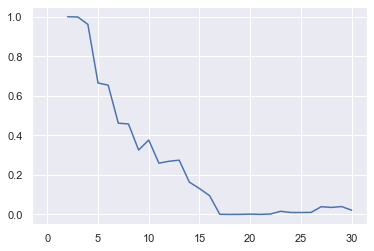

In [126]:
plt.plot(rsquared)

rsquared.index(0.43737319899293914)
plt.title("R-Squared from expanding window regression")
plt.xlabel("Observation")

We use 8 as our peak, so that the model explains around 45% of the variation in the data.

In [128]:
# AR(1) model with static coefficients

y = df_regression_train["logClose"].iloc[-8:]
x = df_regression_train["Lag1"].iloc[-8:]
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
results.summary()

D:\anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logClose   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     5.061
Date:                Mon, 08 Mar 2021   Prob (F-statistic):             0.0655
Time:                        11:22:01   Log-Likelihood:                 21.758
No. Observations:                   8   AIC:                            -39.52
Df Residuals:                       6   BIC:                            -39.36
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0174      0.008      2.151      0.075      -0.002       0.037
Lag1          -0.8126      0.361     -2.250      0.065      -1.696       0.071
==============================================================================
Omnibus:                        1.010   Durbin-Watson:                   1.341
Prob(Omnibus):                  0.603   Jarque-Bera (JB):                0.611
Skew:                          -0.190   Prob(JB):                        0.737
Kurtosis:                       1.700   Cond. No.                         55.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

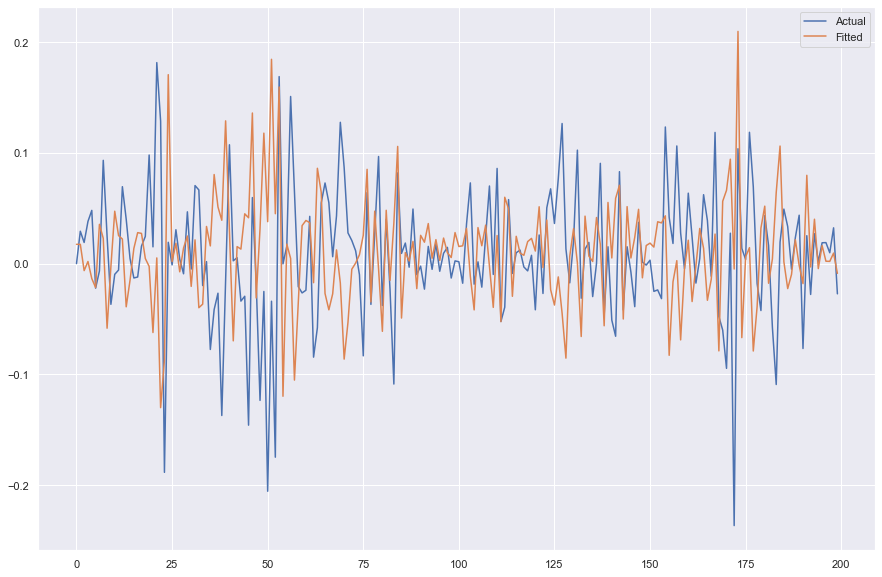

In [130]:
fitted = 0.0174 + -0.8126*df_regression_train["Lag1"]

ax = plt.figure(figsize=(15,10));
plt.plot(df_regression_train["logClose"]);
plt.plot(fitted);
plt.legend(["Actual","Fitted"]);

In [132]:
df_2 = pd.DataFrame({"Fitted Value":fitted,
                        "Actual":df_regression_train["logClose"]})

In [133]:
df_2["Residuals"] = df_2["Fitted Value"] - df_2["Actual"]

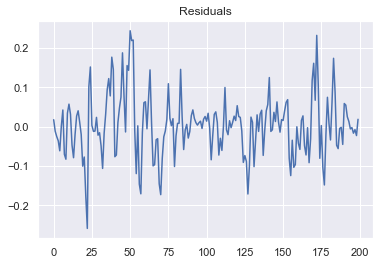

In [135]:
df_2.Residuals.plot()
plt.title("Residuals");

In [136]:
true_neg = np.sum((df_2["Fitted Value"] <0) & (df_2["Actual"] <0))

In [137]:
true_pos = np.sum((df_2["Fitted Value"] >0) & (df_2["Actual"] >0))

In [139]:
accuracy = (true_neg + true_pos)/len(df_2)
accuracy

0.53

This isn't exactly a great accuracy on the hit rate, but at least it's > 50%. We now attempt to see how our model does on the test data.

Text(0.5, 1.0, 'Actual vs Fitted - Test Data')

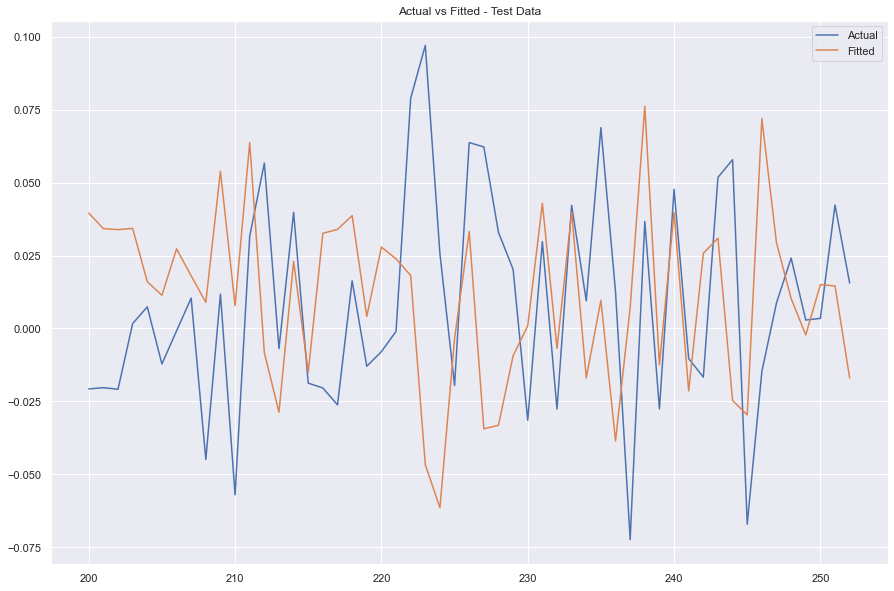

In [140]:
fitted_test = 0.0174 + -0.8126*df_regression_test["Lag1"]
ax = plt.figure(figsize=(15,10))

plt.plot(df_regression_test["logClose"])
plt.plot(fitted_test)
plt.legend(["Actual","Fitted"])
plt.title("Actual vs Fitted - Test Data")

In [142]:
df_2_test = pd.DataFrame({"Fitted Value":fitted_test,
                        "Actual":df_regression_test["logClose"]})

Text(0.5, 1.0, 'Residuals - Test Data')

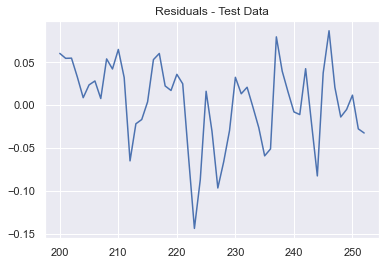

In [143]:
df_2_test["Residuals"] = df_2_test["Fitted Value"] - df_2_test["Actual"]
df_2_test["Residuals"].plot()
plt.title("Residuals - Test Data")

In [172]:
true_neg_test = np.sum((df_2_test["Fitted Value"] <0) & (df_2_test["Actual"] <0))
true_pos_test = np.sum((df_2_test["Fitted Value"] >0) & (df_2_test["Actual"] >0))

accuracy = (true_neg_test + true_pos_test)/len(df_2_test)
accuracy

0.49056603773584906

In [173]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,rolling_mean,rolling_std,logClose,log_rolling_mean,log_rolling_std
0,2020-01-02,84.900002,86.139999,84.342003,86.052002,86.052002,47660500,NaN,NaN,4.454952,NaN,NaN
1,2020-01-03,88.099998,90.800003,87.384003,88.601997,88.601997,88892500,NaN,NaN,4.484154,NaN,NaN
2,2020-01-06,88.094002,90.311996,88.000000,90.307999,90.307999,50665000,NaN,NaN,4.503226,NaN,NaN
3,2020-01-07,92.279999,94.325996,90.671997,93.811996,93.811996,89410500,92.728570,4.510497,4.541293,4.528653,0.048979
4,2020-01-08,94.739998,99.697998,93.646004,98.428001,98.428001,155721500,95.431427,5.419939,4.589325,4.557045,0.056205
...,...,...,...,...,...,...,...,...,...,...,...,...
248,2020-12-24,642.989990,666.090027,641.000000,661.770020,661.770020,22865600,660.344290,18.015480,6.494918,6.492447,0.026994
249,2020-12-28,674.510010,681.400024,660.799988,663.690002,663.690002,32278600,668.317147,23.968305,6.497815,6.504217,0.035603
250,2020-12-29,661.000000,669.900024,655.000000,665.989990,665.989990,22910800,NaN,NaN,6.501275,NaN,NaN
251,2020-12-30,672.000000,696.599976,668.359985,694.780029,694.780029,42846000,NaN,NaN,6.543595,NaN,NaN


As can be seen, our model performs slightly worse on the hit-rate than if we were to guess each time. What can we conclude? Perhaps that due to RH, Ford eating into the market share etc. that Tesla stock is pretty unpredictable, and that an AR(1) model isn't the best thing to go for...

We now try again, using a more sophisticated ARIMA model. We use an ARIMA(1,1,1) model.

In [174]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,rolling_mean,rolling_std,logClose,log_rolling_mean,log_rolling_std
0,2020-01-02,84.900002,86.139999,84.342003,86.052002,86.052002,47660500,NaN,NaN,4.454952,NaN,NaN
1,2020-01-03,88.099998,90.800003,87.384003,88.601997,88.601997,88892500,NaN,NaN,4.484154,NaN,NaN
2,2020-01-06,88.094002,90.311996,88.000000,90.307999,90.307999,50665000,NaN,NaN,4.503226,NaN,NaN
3,2020-01-07,92.279999,94.325996,90.671997,93.811996,93.811996,89410500,92.728570,4.510497,4.541293,4.528653,0.048979
4,2020-01-08,94.739998,99.697998,93.646004,98.428001,98.428001,155721500,95.431427,5.419939,4.589325,4.557045,0.056205
...,...,...,...,...,...,...,...,...,...,...,...,...
248,2020-12-24,642.989990,666.090027,641.000000,661.770020,661.770020,22865600,660.344290,18.015480,6.494918,6.492447,0.026994
249,2020-12-28,674.510010,681.400024,660.799988,663.690002,663.690002,32278600,668.317147,23.968305,6.497815,6.504217,0.035603
250,2020-12-29,661.000000,669.900024,655.000000,665.989990,665.989990,22910800,NaN,NaN,6.501275,NaN,NaN
251,2020-12-30,672.000000,696.599976,668.359985,694.780029,694.780029,42846000,NaN,NaN,6.543595,NaN,NaN


In [180]:
df_log = df[['Date','logClose']]
df_log

,Date,logClose
0,2020-01-02,4.454952
1,2020-01-03,4.484154
2,2020-01-06,4.503226
3,2020-01-07,4.541293
4,2020-01-08,4.589325
...,...,...
248,2020-12-24,6.494918
249,2020-12-28,6.497815
250,2020-12-29,6.501275
251,2020-12-30,6.543595


In [183]:
model = ARIMA(df_log["logClose"], order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

D:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:             D.logClose   No. Observations:                  252
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 368.964
Method:                       css-mle   S.D. of innovations              0.056
Date:                Mon, 08 Mar 2021   AIC                           -729.927
Time:                        12:00:33   BIC                           -715.810
Sample:                             1   HQIC                          -724.247
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0081      0.001      8.777      0.000       0.006       0.010
ar.L1.D.logClose     0.9596      0.019     49.803      0.000       0.922       0.997
ma.L1.D.logClose    -1.0000 

D:\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


Alas the P values equalling zero probably suggest this isn't the way to go either...